ITERATIVE FUNCTION

#We have the NU as the input, and it returns Y as the output. So we want to iterate that but changing the NU

In [1]:
import os
import numpy as np
from DMF_model import DMF_sim, DMF_parameters

In [2]:
# Create folder to store the results
folder = "COMBIS"
folder_path = os.path.join(os.getcwd(), folder)
if not os.path.exists(folder_path):
    os.mkdir(folder_path)

In [117]:
# DMF parameters
P = DMF_parameters({})
P['sigma'] = 0.02  # no noise

# Simulation parameters   
t_sim = 3 # simulation time
t_start = 0.5 # stimulation start time
t_stop = 2.5 # stimulation stop time
dt = P['dt']     # integration time step
P['T'] = t_sim

transient_end = int(0.1/dt) # end of initial transient

# layer specific external input
stim_start = int(t_start/dt)    # start of stimulation
stim_end   = int(t_stop/dt)    # end of stimulation
sim_steps = int(t_sim/dt)       # number of simulation steps

stim_index = range(stim_start,stim_end) # indices of stimulation
input_template = np.zeros(sim_steps) # input current
input_template[stim_index] = 1.0 # input current during stimulation (later just multiply with the specific input intensity)

# Define the possible values for each input intensity.
valuesI = [50, 100, 150, 200, 250, 300]
valuesLayer = range(8)

# Create an array of all possible combinations for each input
input_combinations = np.array(np.meshgrid(valuesI, valuesI)).T.reshape(-1, 2)
layer_combinations = np.array(np.meshgrid(valuesLayer, valuesLayer)).T.reshape(-1, 2)

# repeat each input combination for each layer combination
input_combinations = np.repeat(input_combinations, len(layer_combinations), axis=0)
layer_combinations = np.tile(layer_combinations, (len(valuesI)**2, 1))

# repeat each input combination and layer combination 5 times
input_combinations = np.repeat(input_combinations, 5, axis=0)
layer_combinations = np.repeat(layer_combinations, 5, axis=0)

# Create random input combinations centered around the original input combinations
input_combinations = input_combinations + np.random.uniform(-50, 49, input_combinations.shape)

# save input and layer combinations
np.save(os.path.join(folder_path, "input_combinations.npy"), input_combinations)
np.save(os.path.join(folder_path, "layer_combinations.npy"), layer_combinations)

In [108]:
# The loop

baseline_duration_added = 10
baseline_duration_steps = int(baseline_duration_added/dt)
baseline = np.load("baseline.npy")
baseline = baseline[:baseline_duration_steps,:]


duration = sim_steps - transient_end 
total_number_combinations = len(input_combinations)

# divide the total number of combinations into 10 batches and save each batch separately
batch_size = int(total_number_combinations/10)
Y_baseline = np.tile(baseline, (batch_size,1,1))
Y_baseline = np.reshape(Y_baseline, (-1,8, batch_size))

Y = np.zeros((duration, 8, batch_size))
batch_counter = 0
for total_counter, (current, layer) in enumerate(zip(input_combinations, layer_combinations)):
    U = np.zeros((sim_steps, 8))
    U[:, layer[0]] = input_template * current[0]
    U[:, layer[1]] = input_template * current[1]

    # Run the simulation
    I, _, _ = DMF_sim(U, P)
    Y[:, :, batch_counter] = I[transient_end:, :]
    batch_counter += 1
    if (total_counter + 1) % batch_size == 0:
        
        Y = np.append(Y, Y_baseline, axis = 0)
        #break # To only run one batch.
        # Save the results and include the batch number in the file name with leading zeros
        np.save(os.path.join(folder_path, f'Y_{batch_counter:02d}.npy'), Y)
        
        Y = np.zeros((duration, 8, batch_size))
        batch_counter = 0

        

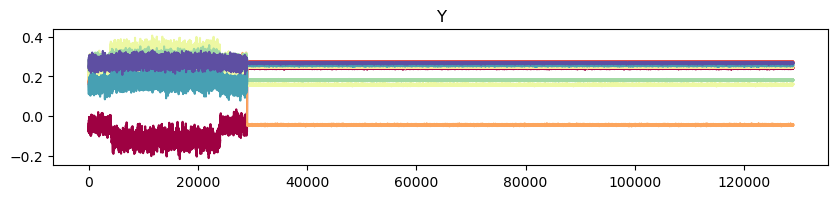

In [100]:
# Making the graph

import pylab as plt

file_path = os.path.join(folder_path, "Y_03.npy") # This is the file for the first batch
Y03 = np.load(file_path)

populations = np.array(['L23E', 'L23I', 'L4E', 'L4I', 'L5E', 'L5I', 'L6E', 'L6I'])
colors      = plt.cm.Spectral(np.linspace(0, 1, len(populations)))
plt.figure(figsize=(10, 6))
plt.subplot(311)
plt.gca().set_prop_cycle(plt.cycler('color', plt.cm.Spectral(np.linspace(0, 1, 8))))
plt.title('Y')
plt.plot(Y03[:,:,2]) # The third dimension is the input-layer combination selected.
# plt.xlim([0, len(duration + baseline_duration_steps)-1])

In [128]:
# From here on out these are m

duration = sim_steps - transient_end 
total_number_combinations = len(input_combinations)
batch_size = int(total_number_combinations/10)
Y = np.zeros((duration, 8, batch_size))

baseline_duration_added = 10
baseline_duration_steps = int(baseline_duration_added/dt)
baseline = np.load("baseline.npy")
baseline = baseline[:baseline_duration_steps,:]

Y_baseline = np.tile(baseline, (batch_size,1,1))
Y_baseline2 = np.reshape(Y_baseline, (-1,8, batch_size))

Y2 = np.append(Y, Y_baseline2, axis = 0)

baseline_3D = baseline[:,:,np.newaxis]
baseline_3D = np.zeros((baseline_duration_steps, 8, ))
Y3 = np.concatenate([Y, baseline_3D], axis = 0)

ValueError: all the input array dimensions except for the concatenation axis must match exactly, but along dimension 2, the array at index 0 has size 1152 and the array at index 1 has size 1

In [129]:
#print(Y_baseline2)
baseline_3D.shape
#Y2.shape
#print(total_number_combinations)

(100000, 8, 1)